In [15]:
import numpy as np
import pandas as pd
import math
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf

In [16]:
# Total RIS elements M:
M = 256
sigma = np.power(10,-8.5)       #-55
num_users = 4
# Coordinates of AP(x_ap, y_ap, z_ap):
AP = [0, 0, 0]

# Coordinates of RIS(x_r, y_r, z_r):
RIS = [300, 0, 0]

# Coordinates of user k(x_k, y_k, z_k):
users = []
for user in range(num_users):
    users.append([np.random.randint(-500, 800), np.random.randint(-500,500), np.random.randint(-500,500)])

def distance(p1, p2):
    return math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2 + (p1[2]-p2[2])**2)

distance(AP, RIS), distance(AP, users[0]), distance(RIS, users[0])

(300.0, 572.7669683213235, 759.6459701729484)

In [17]:
# Calculating NLos vectors for v, gk:
v_nlos = np.random.normal(0, math.sqrt(0.5), size=(M,1)) + np.random.normal(0, math.sqrt(0.5), size=(M,1))
gk_nlos = np.random.normal(0, math.sqrt(0.5), size=(M,1)) + np.random.normal(0, math.sqrt(0.5), size=(M,1))
rk_nlos = np.random.normal(0, math.sqrt(0.5), size=(1,1)) + np.random.normal(0, math.sqrt(0.5), size=(1,1))


v_nlos = v_nlos.ravel().tolist()
gk_nlos = gk_nlos.ravel().tolist()
rk_nlos = rk_nlos.ravel().tolist()

In [18]:
# Generating v_los:
v_los = []

def sin_a_AR(x1,x2,y1,y2):
    return (y1-y2)/math.sqrt((x1-x2)**2 + (y1-y2)**2)

for m in range(1, M+1):
    v_los.append( math.cos((m-1)*math.pi*sin_a_AR(RIS[0], AP[0], RIS[1], AP[1])) 
              + (1j)*math.sin((m-1)*math.pi*sin_a_AR(RIS[0], AP[0], RIS[1], AP[1])))

In [19]:
# Generating gk_los:
gk_los = [[] for _ in range(num_users)]

for user in range(num_users):
    for m in range(1, M+1):
        gk_los[user].append( math.cos((m-1)*math.pi*sin_a_AR(users[user][0], RIS[0], users[user][1], RIS[1])) 
                         + (1j)*math.sin((m-1)*math.pi*sin_a_AR(users[user][0], RIS[0], users[user][1], RIS[1])))

In [20]:
# Generating v[n]:
v = []
rho_0 = 30       # actual rho_0 = -30 (using 1j later)
d_0 = 1
alpha = 3*(10**(-4))
K_AR = 3
K_RU = 3

def PL(d):
    # print(rho_0*((d/d_0)**alpha))
    return rho_0*((d/d_0)**alpha)

def generate_v():
    for m in range(1, M+1):
        v.append( 1j*math.sqrt(PL(300)) * (math.sqrt(K_AR/(K_AR+1)) *v_los[m-1] + math.sqrt(1/(K_AR+1)) *v_nlos[m-1]) )
    return v

In [21]:
# Generating g_k[n]:
gk = [[] for _ in range(num_users)]

def generate_gk():
    for user in range(num_users):
        for m in range(1, M+1):
            gk[user].append( 1j*math.sqrt(PL(distance(RIS, users[user]))) * (math.sqrt(K_RU/(K_RU+1)) *gk_los[user][m-1] + math.sqrt(1/(K_RU+1)) *gk_nlos[m-1]) )
    return gk   

In [22]:
rk = [[] for _ in range(num_users)]

def generate_rk():
    for user in range(num_users):
        rk[user].append( 1j*math.sqrt(PL(distance( AP, users[user]))) *rk_nlos[0])
    return rk

In [23]:
# Generating theta
def generate_theta():
    theta = []
    for m in range(M):
        theta.append(np.random.uniform(0, 2*math.pi, M))
    # theta.ravel().tolist()
    return theta
# theta_matrix = generate_theta()
# theta = [theta_matrix[i][i] for i in range(len(theta_matrix))]

In [24]:
gk = generate_gk()
v = generate_v()
rk = generate_rk()
# print(gk)
# print(v)
# print(rk)

user_power = np.power(10,-2.35)    # 24
# print(theta_0)
# print(len(rk[0]))
# print(len(theta_0))
# print(len(gk))
# df_u1 = pd.DataFrame(list(zip(gk, v, rk, theta_0)), columns=['gk', 'v', 'rk', 'theta_0'])

X = pd.DataFrame()
for user in range(num_users):
    dic = {}
    for i in range(len(gk[user])):
        dic['gk'+str(i)] = gk[user][i]
    for i in range(len(v)):
        dic['v'+str(i)] = v[i]
    dic['rk'] = rk[user]
    x = pd.DataFrame.from_dict(dic)

    X = pd.concat([X,x])

y = pd.DataFrame()
for user in range(num_users):
    theta_matrix = generate_theta()
    theta = [theta_matrix[i][i] for i in range(len(theta_matrix))]
    y_dic = {}
    for i in range(len(theta)):
        y_dic['theta'+str(i)] = [theta[i]]
    y_dic['pk'] = [user_power]
    # print(y_dic)
    y_df = pd.DataFrame.from_dict(y_dic)

    y = pd.concat([y, y_df])

print(X.shape, y.shape)
print(X.head())

(4, 513) (4, 257)
                  gk0                 gk1                 gk2  \
0  0.000000+3.638649j -2.341041+2.054767j -4.073432-2.600551j   
0  0.000000+3.638333j  2.908338+1.676708j  4.597573-3.855204j   
0  0.000000+3.638292j -3.625484-5.141260j  4.681582-5.829135j   
0  0.000000+3.638431j  4.680523-1.279258j  1.570904-9.520356j   

                  gk3                 gk4                 gk5  \
0 -4.746766-2.141657j -4.185982+0.728405j -2.536879-4.140819j   
0  4.359619-4.135656j  2.294221-1.187404j -0.732859-4.818021j   
0 -2.419835+1.829127j -1.556852-1.515975j  4.430196+1.579773j   
0 -4.153287-4.556163j -2.964854+6.677626j  3.158206+3.417914j   

                  gk6                 gk7                 gk8  \
0 -0.228210-7.183016j  2.139792+1.927489j  3.951467+2.275781j   
0 -3.452742-5.698906j -4.725321+5.704902j -4.017162+7.438456j   
0 -4.163853-0.159180j  0.946581+1.513177j  2.941534+8.634554j   
0  4.024830-4.958721j -1.807369+1.775373j -4.631429+5.953088j   

    

In [25]:
class NeuralNetwork:
    def __init__(self):
        self.model = keras.models.Sequential()
        self.gk = X[[col for col in X if col.startswith('gk')]].to_numpy()
        self.v = X[[col for col in X if col.startswith('v')]].to_numpy()
        self.rk = X[[col for col in X if col.startswith('rk')]].to_numpy()

    def loss_func(self, y_true, y_pred):
        hk_final = 0
        for user in range(num_users):
            theta_1 = tf.linalg.diag(y_pred[:,:M][user])
            # pk = y_pred[:,-1]
            # pk_ = pk[0]
            # print(pk_)
            v_ = tf.transpose(tf.convert_to_tensor(self.v[user], dtype=tf.complex128))
            # print(v_)
            a = tf.math.conj(tf.convert_to_tensor(self.gk[user]))
            # print(a)
            theta_1= tf.cast(theta_1, tf.complex128)
            b = tf.tensordot(theta_1, v_, axes=1)
            b_ = tf.convert_to_tensor(b)
            # print(b_)
            rk_ = tf.convert_to_tensor(self.rk[user], dtype=tf.complex128)
            # print(rk_)
            c = tf.tensordot(a, b_, axes=1)
            c_ = tf.convert_to_tensor(c)
            # print(c_)
            hk = (tf.linalg.norm(rk_ + c_))**2
            # print(hk)
            hk_ = tf.fill((1,), hk)
            # print(hk_)
            hk_final = hk_final + hk_
            # print(hk_)
        return -hk_final
        # RkO = 1/4*(np.log2( 1+ ((pk[0] * hk) * 4)/sigma**2 )) #4 -> users
        # rate = (pk*hk)
    # def loss_func(self, y_true, y_pred):
    #     tf.print(y_pred)
    #     squared_difference = tf.square(y_true - y_pred)
    #     return tf.reduce_mean(squared_difference, axis=-1)

    def InputLayer(self, Input):
        self.model.add(keras.layers.Flatten(input_shape=Input))
    def AddLayers(self, n_layers, neurons, activation):
        for i in range(n_layers):
            self.model.add(keras.layers.BatchNormalization())
            self.model.add(keras.layers.Dense(neurons[i], activation=activation[i],kernel_initializer='he_normal'))
            # self.model.add(keras.layers.Dropout(0.2))
            # print(self.model.summary())
    def fit(self,loss, X_train, y_train):
        # self.loss_func(X_train, y_train)
        optimizer = keras.optimizers.Adam(learning_rate=0.009)
        self.model.compile(loss=self.loss_func, optimizer=optimizer, run_eagerly=True)
        history = self.model.fit(X_train, y_train, epochs=250)
        # print(type(self.model))
        return history
    
    def predict(self, X):
        y = self.model.predict(X)
        return y

In [26]:
nmodel = NeuralNetwork()
nmodel.InputLayer([X.shape[1]])
nmodel.AddLayers(2,[30,y.shape[1]], ["relu","tanh"])
model = nmodel.fit("mse", X,y)
ypred = nmodel.predict(X)
print("power allocation = ",ypred[0][M])
print("theta[n] = ", ypred[0][:M])

Epoch 1/250
1/1 [==============================] - 0s 43ms/step - loss: -201458.7969
Epoch 2/250
1/1 [==============================] - 0s 34ms/step - loss: -709436.7500
Epoch 3/250
1/1 [==============================] - 0s 47ms/step - loss: -869621.5000
Epoch 4/250
1/1 [==============================] - 0s 39ms/step - loss: -1799033.5000
Epoch 5/250
1/1 [==============================] - 0s 42ms/step - loss: -3853073.5000
Epoch 6/250
1/1 [==============================] - 0s 36ms/step - loss: -5445556.5000
Epoch 7/250
1/1 [==============================] - 0s 40ms/step - loss: -3562007.0000
Epoch 8/250
1/1 [==============================] - 0s 34ms/step - loss: -4977744.5000
Epoch 9/250
1/1 [==============================] - 0s 45ms/step - loss: -6244699.5000
Epoch 10/250
1/1 [==============================] - 0s 35ms/step - loss: -9189569.0000
Epoch 11/250
1/1 [==============================] - 0s 44ms/step - loss: -12871270.0000
Epoch 12/250
1/1 [==============================] - 0s

In [27]:
print((model.history))
throughput = [-x for x in model.history['loss']]
throughput1 = []
y = []
i = 0
for x in throughput:
    if i % 25 == 0:
        throughput1.append(x)
    i+=1


{'loss': [-201458.796875, -709436.75, -869621.5, -1799033.5, -3853073.5, -5445556.5, -3562007.0, -4977744.5, -6244699.5, -9189569.0, -12871270.0, -6558475.5, -12257581.0, -17137474.0, -19341978.0, -10710313.0, -12734094.0, -26761392.0, -14847603.0, -20757762.0, -20306022.0, -17431648.0, -21176196.0, -34668372.0, -26018220.0, -30391572.0, -23575978.0, -27564966.0, -29187552.0, -33725072.0, -28205920.0, -38883548.0, -27909906.0, -31497608.0, -37392888.0, -30855092.0, -33955972.0, -32574676.0, -36691952.0, -37189384.0, -34861508.0, -36631724.0, -36616736.0, -33592896.0, -37403652.0, -36731428.0, -40033752.0, -38234896.0, -37422124.0, -37299532.0, -36611480.0, -38533980.0, -38656124.0, -38224456.0, -37245636.0, -35269112.0, -37450716.0, -40111580.0, -38048136.0, -40914620.0, -38692540.0, -40969308.0, -40396060.0, -35830144.0, -39018172.0, -36857036.0, -41586964.0, -39270028.0, -39897832.0, -37453772.0, -39055144.0, -36326744.0, -37526812.0, -39365420.0, -40332000.0, -40189728.0, -36499752.

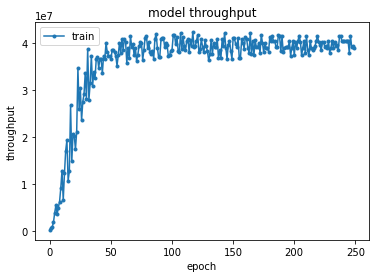

In [28]:
plt.plot(throughput,marker = ".")
# plt.plot(model.history['val_loss'])
plt.title('model throughput')
plt.ylabel('throughput')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()